In [1]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kaggle/5_Digit_recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Kaggle/5_Digit_recognizer/Untitled0.ipynb
/content/drive/MyDrive/Kaggle/5_Digit_recognizer/sample_submission.csv
/content/drive/MyDrive/Kaggle/5_Digit_recognizer/test.csv
/content/drive/MyDrive/Kaggle/5_Digit_recognizer/train.csv


In [2]:
import warnings
warnings.filterwarnings('ignore',category=UserWarning)

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/5_Digit_recognizer/train.csv')
test  = pd.read_csv('/content/drive/MyDrive/Kaggle/5_Digit_recognizer/test.csv')

In [4]:
train_labs = pd.DataFrame()
train_labs = train['label'].values

In [5]:
train_data = pd.DataFrame()
train_data = train.iloc[:, 1:]

In [6]:
train_data = train_data.astype('float32') / 255
test = test.astype('float32') / 255

In [7]:
from tensorflow.keras.utils import to_categorical
train_labs = to_categorical(train_labs)

In [8]:
train_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(-0.5, 241.5, 31.5, -0.5)

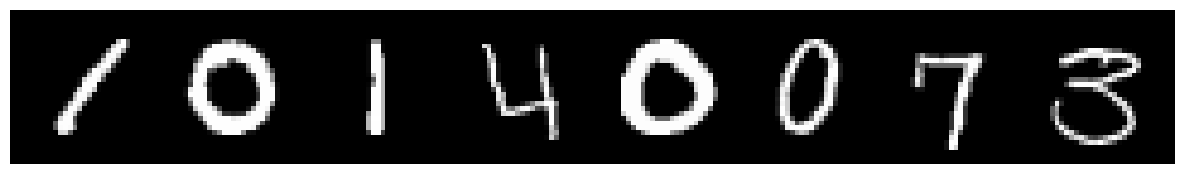

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

selected_indices = np.arange(8) # selected_indices is a numpy array of first 8 integers [0 to 7].

grid = make_grid(torch.Tensor((train_data.iloc[selected_indices].values).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.figure(figsize=(16, 2))
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')

In [10]:
n_train = len(train)
n_pixels = len(train.columns) - 1
n_class = len(set(train['label']))

In [11]:
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from PIL import Image, ImageOps, ImageEnhance
from torchvision.transforms import RandomRotation
from torchvision.transforms import RandomAffine

In [12]:
class process_data(Dataset):

    def __init__(self, file_path, transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])):

        df = pd.read_csv(file_path)

        if len(df.columns) == n_pixels:  # test data
            self.X = df.values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = None
        else:                            # train data
            self.X = df.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = torch.from_numpy(df.iloc[:, 0].values)

        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [14]:
train_dataset_v1 = process_data('/content/drive/MyDrive/Kaggle/5_Digit_recognizer/train.csv', transform = transforms.Compose([transforms.ToPILImage(), RandomRotation(degrees=20), RandomAffine(3), transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset_v1 = process_data('/content/drive/MyDrive/Kaggle/5_Digit_recognizer/test.csv')

In [15]:
batch_size = 64

# creating DataLoader instances for both training and testing datasets
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_v1,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset_v1,
                                           batch_size=batch_size, shuffle=False)

In [16]:
import torch.nn as nn
import math
import random
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(                             # Conv2D feature extraction
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(                              # feed forward network
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
        for m in self.features.children():                                  # Initializing weights for convoluted layer
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        for m in self.classifier.children():                                # Initializing weights for feed forward classifier
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [18]:
model = Net()

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.003) # optimizer is responsible for adjusting the parameters of the model

criterion = nn.CrossEntropyLoss(reduction='sum')

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
def train(epoch):
    model.train() # indicates that the model is in train mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

    exp_lr_scheduler.step()

In [22]:
def evaluate(data_loader):
    model.eval()   # indicates that the model is in evaluation mode
    loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss += F.cross_entropy(output, target, reduction='sum').item()  # Updated to use reduction='sum'

            pred = output.argmax(dim=1, keepdim=True)  # Simplified
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(data_loader.dataset)

    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [23]:
n_epochs = 1

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)


Average loss: 0.0648, Accuracy: 41103/42000 (97.864%)



In [24]:
def prediction(data_loader):
    model.eval()
    test_pred = torch.LongTensor()   # Creates an empty tensor of type LongTensor used for storing labels in classification tasks

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            if torch.cuda.is_available():    # cuda was not available
                data = data.cuda()

            output = model(data)
            pred = output.cpu().data.max(1, keepdim=True)[1]
            test_pred = torch.cat((test_pred, pred), dim=0)

    return test_pred

In [25]:
test_pred = prediction(test_loader)

In [26]:
submission = pd.DataFrame(np.c_[np.arange(1, len(test_dataset_v1)+1)[:,None], test_pred.numpy()],
                      columns=['ImageId', 'Label'])

In [27]:
submission.to_csv("/content/drive/MyDrive/Kaggle/5_Digit_recognizer/submission.csv",index=False)